In [1]:
# https://www.kaggle.com/crowdflower/twitter-airline-sentiment
!wget -nc https://lazyprogrammer.me/course_files/AirlineTweets.csv

O arquivo “AirlineTweets.csv” já existe, não será baixado.



In [2]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

import torch

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
# ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap='Blues')

# Diff
from typing import Dict

In [3]:
df_ = pd.read_csv("AirlineTweets.csv")

In [4]:
df_.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [5]:
df = df_[['airline_sentiment', 'text']].copy()

In [6]:
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


<AxesSubplot: >

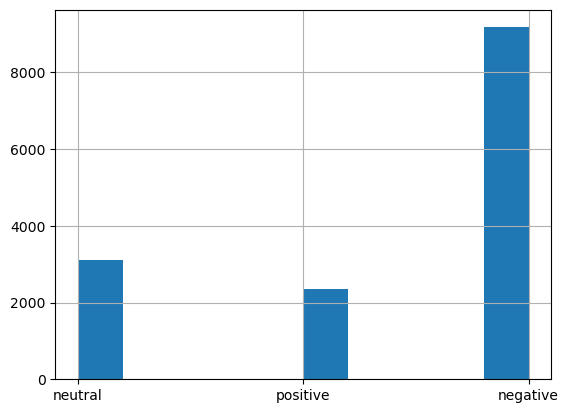

In [7]:
df['airline_sentiment'].hist()

In [8]:
target_map = {
    'positive': 1,
    'negative': 0,
    'neutral': 2,
}
df['target'] = df['airline_sentiment'].map(target_map)
df.head()

,airline_sentiment,text,target
0,neutral,@VirginAmerica What @dhepburn said.,2
1,positive,@VirginAmerica plus you've added commercials t...,1
2,neutral,@VirginAmerica I didn't today... Must mean I n...,2
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0


In [9]:
df2 = df[['text', 'target']]
# Not documented info: targets must have the column name label
# sentence may have other names, but not label
df2.columns = ['sentence', 'label']
df2.to_csv("data.csv", index=False)

In [10]:
!head data.csv

sentence,label
@VirginAmerica What @dhepburn said.,2
@VirginAmerica plus you've added commercials to the experience... tacky.,1
@VirginAmerica I didn't today... Must mean I need to take another trip!,2
"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",0
@VirginAmerica and it's a really big bad thing about it,0
"@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.
it's really the only bad thing about flying VA",0
"@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)",1
"@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP",2


In [11]:
from datasets import load_dataset
raw_dataset = load_dataset('csv', data_files='data.csv')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [12]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 14640
    })
})

In [13]:
split = raw_dataset['train'].train_test_split(test_size=.3, seed=42)

In [14]:
split

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 10248
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 4392
    })
})

In [15]:
# if you have multiple csv files:
# load_dataset('csv', data_files=['file1.csv', 'file2.csv', ...])

In [16]:
# if you already have a train-test split:
# load_dataset(
#     "csv", data_files={"train": ["train1.csv", "train2.csv"], "test": "test.csv"}
# )


In [17]:
checkpoint = 'distilbert-base-cased'


In [18]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [19]:
def tokenize_fn(batch):
  return tokenizer(batch['sentence'], truncation=True)

In [20]:
tokenized_datasets = split.map(tokenize_fn, batched=True)

Map:   0%|          | 0/10248 [00:00<?, ? examples/s]

Map:   0%|          | 0/4392 [00:00<?, ? examples/s]

In [21]:
print(tokenized_datasets['train'][0])

{'sentence': '@USAirways Gave up after more than 2 hours on hold. Still need that receipt; last time it was promised, it never arrived. Help?!', 'label': 0, 'input_ids': [101, 137, 3066, 3161, 8520, 144, 8308, 1146, 1170, 1167, 1190, 123, 2005, 1113, 2080, 119, 4209, 1444, 1115, 1231, 27333, 132, 1314, 1159, 1122, 1108, 5163, 117, 1122, 1309, 2474, 119, 12056, 136, 106, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [22]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 10248
    })
    test: Dataset({
        features: ['sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 4392
    })
})

In [23]:
# The difference from notebook Fine-Tunning Sentiment Custom Dataset starts here
# with the AutoConfig import
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoConfig 

In [24]:
config = AutoConfig.from_pretrained(checkpoint)

In [25]:
config

DistilBertConfig {
  "_name_or_path": "distilbert-base-cased",
  "activation": "gelu",
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.31.0",
  "vocab_size": 28996
}

In [26]:
# diff (new cell)
config.id2label

{0: 'LABEL_0', 1: 'LABEL_1'}

In [27]:
# diff (new cell)
config.label2id

{'LABEL_0': 0, 'LABEL_1': 1}

In [28]:
# diff (new cell)
config.id2label = {v:k for k, v in target_map.items()}
config.label2id = target_map

In [29]:
# diff (new cell)
config.id2label

{1: 'positive', 0: 'negative', 2: 'neutral'}

In [30]:
# diff (new cell)
config.label2id

{'positive': 1, 'negative': 0, 'neutral': 2}

In [31]:
# Diff (add config to from_pretrained method)
# Diff (must exclude num_labels argument, since will be infered by the config parameters)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, config=config)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'classifier.bias', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
!pip install torchinfo

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [33]:
from torchinfo import summary

In [34]:
summary(model)

Layer (type:depth-idx)                                  Param #
DistilBertForSequenceClassification                     --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              22,268,928
│    │    └─Embedding: 3-2                              393,216
│    │    └─LayerNorm: 3-3                              1,536
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             42,527,232
├─Linear: 1-2                                           590,592
├─Linear: 1-3                                           2,307
├─Dropout: 1-4                                          --
Total params: 65,783,811
Trainable params: 65,783,811
Non-trainable params: 0

In [35]:
training_args = TrainingArguments(
    output_dir="training_dir",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
)


In [36]:
def compute_metrics(logits_and_labels):
    logits, labels = logits_and_labels
    predictions = np.argmax(logits, axis=-1)
    acc = np.mean(predictions == labels)
    f1 = f1_score(labels, predictions, average="macro")
    return {"accuracy": acc, "f1": f1}


In [37]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [38]:
trainer.train()

/home/bruno/anaconda3/envs/gpt/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/1923 [00:00<?, ?it/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 0.539, 'learning_rate': 3.699947997919917e-05, 'epoch': 0.78}


  0%|          | 0/69 [00:00<?, ?it/s]

{'eval_loss': 0.4218588173389435, 'eval_accuracy': 0.8340163934426229, 'eval_f1': 0.7730400234433499, 'eval_runtime': 7.0586, 'eval_samples_per_second': 622.222, 'eval_steps_per_second': 9.775, 'epoch': 1.0}
{'loss': 0.3478, 'learning_rate': 2.399895995839834e-05, 'epoch': 1.56}


  0%|          | 0/69 [00:00<?, ?it/s]

{'eval_loss': 0.48545974493026733, 'eval_accuracy': 0.8362932604735883, 'eval_f1': 0.7707443175145611, 'eval_runtime': 7.1454, 'eval_samples_per_second': 614.664, 'eval_steps_per_second': 9.657, 'epoch': 2.0}
{'loss': 0.232, 'learning_rate': 1.0998439937597505e-05, 'epoch': 2.34}


  0%|          | 0/69 [00:00<?, ?it/s]

{'eval_loss': 0.6186527013778687, 'eval_accuracy': 0.8397085610200364, 'eval_f1': 0.7874530071939142, 'eval_runtime': 7.2489, 'eval_samples_per_second': 605.881, 'eval_steps_per_second': 9.519, 'epoch': 3.0}
{'train_runtime': 198.6377, 'train_samples_per_second': 154.774, 'train_steps_per_second': 9.681, 'train_loss': 0.32483944865607123, 'epoch': 3.0}


TrainOutput(global_step=1923, training_loss=0.32483944865607123, metrics={'train_runtime': 198.6377, 'train_samples_per_second': 154.774, 'train_steps_per_second': 9.681, 'train_loss': 0.32483944865607123, 'epoch': 3.0})

In [39]:
!ls training_dir

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
checkpoint-1282  checkpoint-1923  checkpoint-641


In [40]:
# Let's evaluate each checkpoint generated

# checkpoints = ["checkpoint-641", "checkpoint-1282", "checkpoint-1923"]

# Create a list of checkpoints

# Diff: Do not need num_labels anymore!
# Since this value is infered from the transformers config object
def evalCheckpoints(ckpt_path, checkpoints, config, tokenized_datasets):
    # For each checkpoint, load the model and evaluate it on the test dataset
    columns = ['eval_accuracy', 'eval_f1', 'eval_loss']
    results = pd.DataFrame(columns=columns, index=checkpoints)
    for _ckpt in checkpoints:
        # Diff here: do not need num_labels anymore! Instead we pass the config
        model = AutoModelForSequenceClassification.from_pretrained(ckpt_path + '/' + _ckpt, config=config)
        training_args = TrainingArguments(
            output_dir=ckpt_path,
            evaluation_strategy="epoch",
            save_strategy="epoch",
            num_train_epochs=3,
            per_device_train_batch_size=16,
            per_device_eval_batch_size=64,
        )
        def compute_metrics(logits_and_labels):
            logits, labels = logits_and_labels
            predictions = np.argmax(logits, axis=-1)
            acc = np.mean(predictions == labels)
            f1 = f1_score(labels, predictions, average="macro")
            return {"accuracy": acc, "f1": f1}
        trainer = Trainer(
            model,
            training_args,
            train_dataset=tokenized_datasets["train"],
            eval_dataset=tokenized_datasets["test"],
            tokenizer=tokenizer,
            compute_metrics=compute_metrics,
        )
        result = {k:v for k, v in trainer.evaluate().items() if k in columns}
        results.loc[_ckpt] = result

    results.reset_index(inplace=True)
    results.rename(columns={"index": "checkpoint"}, inplace=True)
    print(results)
    # Plot the evaluation results

    plt.figure(figsize=(10, 6))
    sn.lineplot(x="checkpoint", y="eval_f1", data=results)
    sn.lineplot(x="checkpoint", y="eval_accuracy", data=results)
    # sn.lineplot(x="checkpoint", y="eval_loss", data=results)
    plt.title("Evaluation Metrics")
    plt.show()

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

        checkpoint eval_accuracy   eval_f1 eval_loss
0   checkpoint-641      0.834016   0.77304  0.421859
1  checkpoint-1282      0.836293  0.770744   0.48546
2  checkpoint-1923      0.839709  0.787453  0.618653


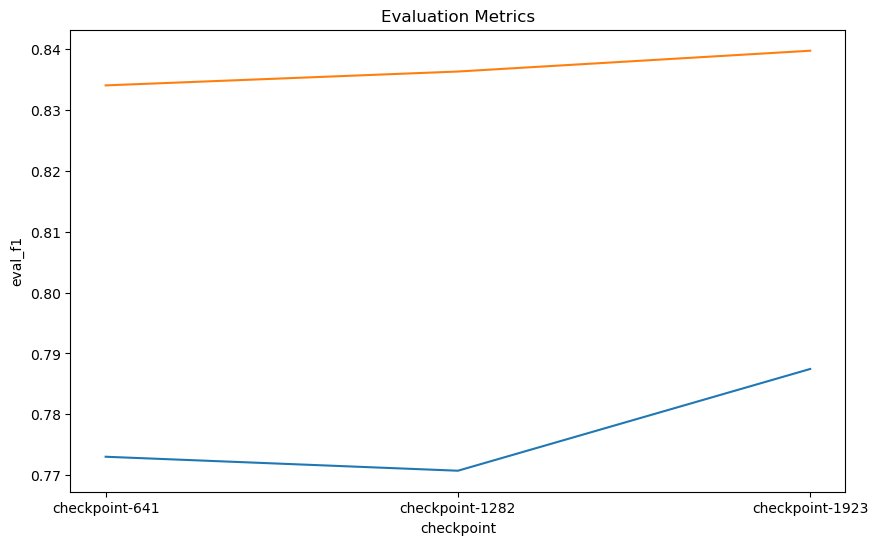

In [41]:
evalCheckpoints("training_dir", ["checkpoint-641", "checkpoint-1282", "checkpoint-1923"], config, tokenized_datasets)

In [42]:
from transformers import pipeline

In [43]:
savedmodel = pipeline('text-classification', model='training_dir/checkpoint-1282', device=0)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [44]:
split['test']

Dataset({
    features: ['sentence', 'label'],
    num_rows: 4392
})

In [45]:
test_pred = savedmodel(split['test']['sentence'])

In [46]:
test_pred[:10]

[{'label': 'positive', 'score': 0.9511092901229858},
 {'label': 'positive', 'score': 0.9583902955055237},
 {'label': 'positive', 'score': 0.5505505204200745},
 {'label': 'positive', 'score': 0.8633303642272949},
 {'label': 'negative', 'score': 0.9323732852935791},
 {'label': 'negative', 'score': 0.99552983045578},
 {'label': 'neutral', 'score': 0.8527319431304932},
 {'label': 'neutral', 'score': 0.6646154522895813},
 {'label': 'positive', 'score': 0.6303641200065613},
 {'label': 'negative', 'score': 0.9956798553466797}]

In [47]:
# Diff: labels are correct. we only need to get the integer index
# Labels are already correct
def getLabel(d, id2label: Dict):
    # Diff here
    return int(id2label[d['label']])

test_pred = [getLabel(d, target_map) for d in test_pred]
test_pred[:10]

[1, 1, 1, 1, 0, 0, 2, 2, 1, 0]

In [48]:
print(split['test']['label'])

[1, 1, 2, 2, 0, 0, 2, 2, 1, 0, 0, 0, 1, 0, 2, 2, 0, 0, 0, 0, 0, 2, 1, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 2, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 2, 2, 1, 2, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 2, 0, 0, 2, 0, 0, 2, 1, 0, 0, 0, 2, 0, 0, 0, 0, 1, 2, 0, 0, 0, 2, 2, 1, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 1, 1, 2, 0, 0, 1, 1, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 1, 2, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 2, 0, 0, 0, 2, 1, 0, 2, 0, 1, 0, 2, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 

In [49]:
print(f"Accuracy: {accuracy_score(y_true=split['test']['label'], y_pred=test_pred)}")

Accuracy: 0.8362932604735883


In [50]:
print(f"f1: {f1_score(y_true=split['test']['label'], y_pred=test_pred, average='macro')}")

f1: 0.7707443175145611


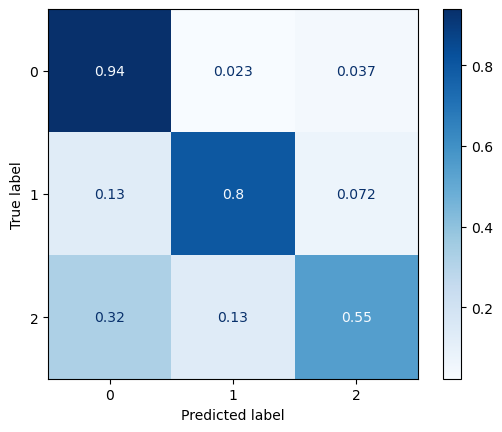

In [51]:
cm = confusion_matrix(y_true=split['test']['label'], y_pred=test_pred, normalize="true")
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap='Blues')

### Exercise: use binary classes and compare to pretrained pipeline from earlier

In [52]:
df.head()


,airline_sentiment,text,target
0,neutral,@VirginAmerica What @dhepburn said.,2
1,positive,@VirginAmerica plus you've added commercials t...,1
2,neutral,@VirginAmerica I didn't today... Must mean I n...,2
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0


In [53]:
df_binary = df[df['airline_sentiment'] != 'neutral']
df_binary.head()

,airline_sentiment,text,target
1,positive,@VirginAmerica plus you've added commercials t...,1
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0
5,negative,@VirginAmerica seriously would pay $30 a fligh...,0
6,positive,"@VirginAmerica yes, nearly every time I fly VX...",1


In [54]:
df2 = df_binary[['text', 'target']]
df2.columns = ['sentence', 'label']
df2.to_csv("data_binary.csv", index=False)
df2.head()

,sentence,label
1,@VirginAmerica plus you've added commercials t...,1
3,@VirginAmerica it's really aggressive to blast...,0
4,@VirginAmerica and it's a really big bad thing...,0
5,@VirginAmerica seriously would pay $30 a fligh...,0
6,"@VirginAmerica yes, nearly every time I fly VX...",1


In [55]:
!head data_binary.csv

sentence,label
@VirginAmerica plus you've added commercials to the experience... tacky.,1
"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",0
@VirginAmerica and it's a really big bad thing about it,0
"@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.
it's really the only bad thing about flying VA",0
"@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)",1
"@virginamerica Well, I didn't…but NOW I DO! :-D",1
"@VirginAmerica it was amazing, and arrived an hour early. You're too good to me.",1
@VirginAmerica I &lt;3 pretty graphics. so much better than minimal iconography. :D,1


In [56]:
raw_dataset_binary = load_dataset('csv', data_files="data_binary.csv")
raw_dataset_binary

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 11541
    })
})

In [57]:
split_binary = raw_dataset_binary['train'].train_test_split(test_size=.3, seed=42)
split_binary

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 8078
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 3463
    })
})

In [58]:
# Diff: new cell. Add new config
config_binary = AutoConfig.from_pretrained(checkpoint)
target_map_binary = {
    'positive': 1,
    'negative': 0
}
config_binary.id2label = {v: k for k, v in target_map_binary.items()}
config_binary.label2idx = target_map_binary

In [59]:
# Diff: new cell
config_binary.id2label 

{1: 'positive', 0: 'negative'}

In [60]:
# Diff: new cell
config_binary.label2idx

{'positive': 1, 'negative': 0}

In [69]:
# Diff: config instead of num_labels, as before
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, config=config_binary)
model

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'classifier.bias', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [70]:
tokenized_datasets_binary = split_binary.map(tokenize_fn, batched=True)

In [71]:
tokenized_datasets_binary

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 8078
    })
    test: Dataset({
        features: ['sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 3463
    })
})

In [72]:
training_args_binary = TrainingArguments(
    "training_dir_binary",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
)

In [73]:
trainer_binary = Trainer(
    model,
    training_args_binary,
    train_dataset=tokenized_datasets_binary['train'],
    eval_dataset=tokenized_datasets_binary['test'],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

In [74]:
trainer_binary.train()

/home/bruno/anaconda3/envs/gpt/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/1515 [00:00<?, ?it/s]

{'loss': 0.2214, 'learning_rate': 3.34983498349835e-05, 'epoch': 0.99}


  0%|          | 0/55 [00:00<?, ?it/s]

{'eval_loss': 0.19716159999370575, 'eval_accuracy': 0.9335835980363847, 'eval_f1': 0.8910976510158878, 'eval_runtime': 6.9317, 'eval_samples_per_second': 499.59, 'eval_steps_per_second': 7.935, 'epoch': 1.0}
{'loss': 0.1041, 'learning_rate': 1.6996699669966998e-05, 'epoch': 1.98}


  0%|          | 0/55 [00:00<?, ?it/s]

{'eval_loss': 0.24106243252754211, 'eval_accuracy': 0.9410915391279238, 'eval_f1': 0.9032938981079635, 'eval_runtime': 6.227, 'eval_samples_per_second': 556.122, 'eval_steps_per_second': 8.832, 'epoch': 2.0}
{'loss': 0.0367, 'learning_rate': 4.950495049504951e-07, 'epoch': 2.97}


  0%|          | 0/55 [00:00<?, ?it/s]

{'eval_loss': 0.3077095150947571, 'eval_accuracy': 0.941380306092983, 'eval_f1': 0.9045016040042031, 'eval_runtime': 6.1809, 'eval_samples_per_second': 560.273, 'eval_steps_per_second': 8.898, 'epoch': 3.0}
{'train_runtime': 184.2369, 'train_samples_per_second': 131.537, 'train_steps_per_second': 8.223, 'train_loss': 0.11983557870679169, 'epoch': 3.0}


TrainOutput(global_step=1515, training_loss=0.11983557870679169, metrics={'train_runtime': 184.2369, 'train_samples_per_second': 131.537, 'train_steps_per_second': 8.223, 'train_loss': 0.11983557870679169, 'epoch': 3.0})

In [75]:
!ls training_dir_binary

checkpoint-1010  checkpoint-1515  checkpoint-505


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

        checkpoint eval_accuracy   eval_f1 eval_loss
0   checkpoint-505      0.933584  0.891098  0.197162
1  checkpoint-1010      0.941092  0.903294  0.241062
2  checkpoint-1515       0.94138  0.904502   0.30771


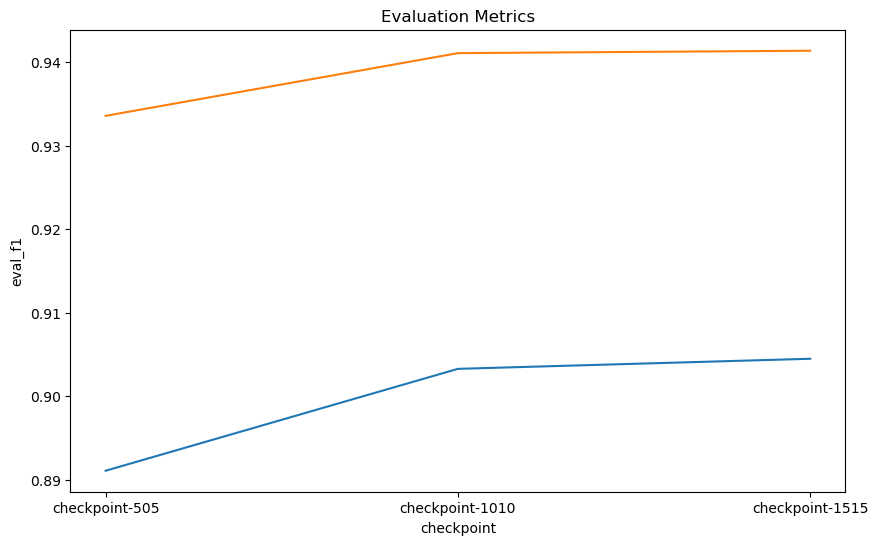

In [76]:
evalCheckpoints("training_dir_binary", ['checkpoint-505', 'checkpoint-1010', 'checkpoint-1515'], config_binary, tokenized_datasets_binary)

In [77]:
savedmodel_binary = pipeline('text-classification', model='training_dir_binary/checkpoint-1515', device=0)

In [78]:
test_pred_binary = savedmodel_binary(split_binary['test']['sentence'])
test_pred_binary[:10]

[{'label': 'positive', 'score': 0.9789749383926392},
 {'label': 'negative', 'score': 0.9998279809951782},
 {'label': 'negative', 'score': 0.9998592138290405},
 {'label': 'negative', 'score': 0.9998418092727661},
 {'label': 'negative', 'score': 0.9998544454574585},
 {'label': 'negative', 'score': 0.9904968738555908},
 {'label': 'positive', 'score': 0.999401330947876},
 {'label': 'negative', 'score': 0.9997557997703552},
 {'label': 'negative', 'score': 0.9998233914375305},
 {'label': 'negative', 'score': 0.9987801909446716}]

In [79]:
test_pred_binary = [getLabel(d, target_map) for d in test_pred_binary]
test_pred_binary[:10]

[1, 0, 0, 0, 0, 0, 1, 0, 0, 0]

In [80]:
print(split_binary['test']['label'])

[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [81]:
print(f"Accuracy: {accuracy_score(y_true=split_binary['test']['label'], y_pred=test_pred_binary)}")

Accuracy: 0.941380306092983


In [82]:
print(f"f1: {f1_score(y_true=split_binary['test']['label'], y_pred=test_pred_binary, average='macro')}")

f1: 0.9045016040042031


#### Conclusão:

Temos uma acurácia com Fine-Tunning de 0.941380306092983, contra 0.8898708950697514 sem Fine-Tunning

Temos f1 com Fine-Tunning de 0.9045016040042031, contra 0.7587777566900741 sem Fine-Tunning

Portanto, nosso modelo com fine tunning foi capaz de melhorar significativamente a performance.